# 分析A/B测试的结果

  
  
## 目录
- [简介](#intro)
- [I - 概率](#probability)
- [II - A/B 测试](#ab_test)
- [III - 回归](#regression)


<a id='intro'></a>
### 简介

对于这个项目，你将要了解的是电子商务网站运行的 A/B 测试的结果。目标是通过AB测试来帮助公司弄清楚他们是否应该使用新的页面，还是保留旧的页面，或者应该将测试时间延长，之后再做出决定。


<a id='probability'></a>
### Ⅰ- 概率

In [2]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

In [3]:
os.chdir(r'D:\Data Analysis\abtest')
df = pd.read_csv('ab_data.csv',encoding = 'ISO-8859-1')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [5]:
df.shape

(294478, 5)

In [6]:
# 计算独立用户数量
df.user_id.nunique()

290584

In [8]:
# 计算独立用户转化的比例
df.query('converted == 1').user_id.nunique() / df.user_id.nunique()

0.12104245244060237

In [9]:
# new_page和treatment不一致的次数
df[((df['group'] == 'treatment') != (df['landing_page'] == 'new_page'))]['user_id'].count()

3893

In [11]:
# 检查缺失值
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [14]:
# 处理 treatment 不与 new_page 一致的行或 control 不与 old_page 一致的行
df2 = df.drop(df[((df['group'] == 'treatment') != (df['landing_page'] == 'new_page'))].index)
df2.shape

(290585, 5)

In [22]:
# df2 中有多少唯一的 user_id
df2.user_id.nunique()

290584

In [23]:
# 找出重复的一个 user_id
df2[df2.user_id.duplicated()==True]['user_id']

2893    773192
Name: user_id, dtype: int64

In [28]:
# 这个重复的 user_id 的行信息是什么
df2.query('user_id == "773192"')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [29]:
# 删除一个含有重复的 user_id 的行，但需要确保你的 dataframe 为 df2
df2 = df2.drop(2893)
df2.shape

(290584, 5)

In [32]:
# 不管什么页面，单个用户的转化率是多少？
df2.converted.mean()

0.11959708724499628

In [37]:
# 将控制组和试验组分别存储到df_ctrl和df_tr中
df_ctrl = df2.query('group == "control"')
df_tr = df2.query('group == "treatment"')

In [38]:
# 控制组的转化率
df_ctrl.converted.mean()

0.1203863045004612

In [39]:
# 试验组的转化率
df_tr.converted.mean()

0.11880806551510564

In [40]:
# 一个用户收到新页面的概率是多少
df_tr.shape[0] / df2.shape[0]

0.5000619442226688

**结论：**

- 通过上面的计算，控制组的转化率为12.04%，试验组的转化率为11.88%，略低于控制组约0.16%。到目前为止我们没有充分的依据来判断新页面是否能带来更多的转化。我们需要通过 **假设检验** 来进一步观察样本转化率的差异值是否具有统计显著性。

<a id='ab_test'></a>
### Ⅱ - A/B测试

现在需要根据提供的所有数据做出决定。如果想假定旧的页面效果更好，除非新的页面在第一种类型的错误中 **错误率为5％** 的情况下才能证明效果更好。  
  
原假设：**$p_{new}$-$p_{old}$**<=0

备择假设：**$p_{new}$-$p_{old}$**>0


In [43]:
# 在原假设中，Pnew 的转化率是多少？
p_new = df2.converted.mean()
p_new

0.11959708724499628

In [44]:
# 在原假设中，Pold 的转化率是多少？
p_old = df2.converted.mean()
p_old

0.11959708724499628

In [45]:
# n_new是多少？
n_new = df_tr.shape[0]
n_new

145310

In [46]:
# n_old是多少？
n_old = df_ctrl.shape[0]
n_old

145274

In [59]:
# 在原假设中，使用 Pnew 转化率模拟 n_new 交易
random.seed(42)
new_page_converted = np.random.choice(2, size=n_new, p=[1-p_new,p_new])
new_page_converted

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [60]:
# 在原假设中，使用 Pold 转化率模拟 n_old 交易
random.seed(42)
old_page_converted = np.random.choice(2, size=n_old, p=[1-p_old,p_old])
old_page_converted

array([1, 0, 1, ..., 1, 0, 0], dtype=int64)

In [61]:
# 计算新旧页面转化率的差值
new_page_converted.mean() - old_page_converted.mean()

-0.0007730638425574032

In [64]:
p_diffs = []
for i in range(10000):
    sample_new = np.random.choice(2, n_new, p = [1 - p_new, p_new])
    sample_old = np.random.choice(2, n_old, p = [1 - p_old, p_old])
    p_diffs.append(sample_new.mean() - sample_old.mean())

(array([  13.,  108.,  532., 1539., 2634., 2705., 1737.,  593.,  122.,
          17.]),
 array([-4.46891485e-03, -3.58378298e-03, -2.69865112e-03, -1.81351926e-03,
        -9.28387391e-04, -4.32555267e-05,  8.41876338e-04,  1.72700820e-03,
         2.61214007e-03,  3.49727193e-03,  4.38240380e-03]),
 <a list of 10 Patch objects>)

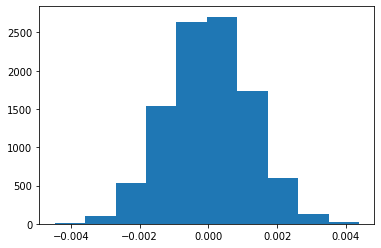

In [65]:
plt.hist(p_diffs)

In [71]:
# 实际观测差异值
obs_diff = df_tr.converted.mean() - df_ctrl.converted.mean()
obs_diff

-0.0015782389853555567

In [72]:
p_diffs = np.array(p_diffs)
(p_diffs > obs_diff).mean()

0.9059

- 上面这个结果即为假设检验的p值。 p值约为0.90，接近于1，说明新旧页面转化率的差异值不具有统计显著性。在显著性水平0.05下，我们没有理由拒绝零假设，即新页面并没有比旧页面带来更高的转化率。

In [74]:
import statsmodels.api as sm

# 计算新旧页面的转化次数
convert_old = df_ctrl.query('converted == 1').shape[0]
convert_new = df_tr.query('converted == 1').shape[0]

# 计算新旧页面的转化人数
n_old = df_ctrl.shape[0]
n_new = df_tr.shape[0]

n_old, convert_old, n_new, convert_new

(145274, 17489, 145310, 17264)

In [77]:
# 使用 stats.proportions_ztest 计算检验统计量 z分数 和 p-值
sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger')

(-1.3109241984234394, 0.9050583127590245)

- 利用z-test测试得到的p值与之前的结果基本一致。p值大于0.05，所以在显著性水平0.05下，我们无法拒绝零假设。和之前的计算得出的结论相同。

<a id='regression'></a>
### III - 回归分析法<br>

在之前的A / B测试中获得的结果也可以通过执行回归来获取。<br><br>
因为每行的值是转化或不转化，因此在这种情况下，我们可以运用 **逻辑回归** 。

In [78]:
df2['intercept'] = 1
df2[['control', 'treatment']] = pd.get_dummies(df['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


In [79]:
#去掉‘control'列，并重新命名’treatment‘列
df2 = df2.drop('control', axis = 1)
df2.rename(columns = {'treatment':'ab_page'}, inplace = True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [97]:
# 使用 statsmodels 导入你的回归模型，预测一个用户是否会发生转化。
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result=lm.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 03 Feb 2020   Pseudo R-squ.:               8.077e-06
Time:                        11:43:54   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**结论：**
- 与ab_page关联的p值为0.190，而在第二部分假设检验中计算得到的p值是0.90。  
  
    
- 逻辑回归中变量的p值与第二部分假设检验的检验方向不同。回归中的原假设是ab_page的系数等于0，备择假设是系数不等于0，是一个双侧检验。  
  
    
- p值的大小可以指示ab_page变量是否有利于预测转化率。这里得到的p值：0.190 > 0.05，所以认为ab_page这个变量，即“用户访问新页面”这个因素，与用户转化率没有太大关系，不适合用于预测转化率。<br><br>


现在，除了测试不同页面的转化率是否会发生变化之外，还要根据用户居住的 **国家** 添加一个影响项。


In [109]:
# 导入 countries.csv 数据集，并将数据集合并在适当的行上
df3 = pd.read_csv('countries.csv',encoding = 'ISO-8859-1')
df3 = df2.merge(df3, on = 'user_id')

In [110]:
df3.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
intercept       0
ab_page         0
country         0
dtype: int64

In [111]:
df3[['CA','UK','US']] = pd.get_dummies(df3['country'])
df3 = df3.drop('US', axis = 1)
df3.sample(5)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK
143334,648423,2017-01-17 22:19:45.587133,treatment,new_page,0,1,1,US,0,0
106219,797754,2017-01-10 16:05:07.378496,control,old_page,0,1,0,US,0,0
7609,765401,2017-01-20 21:09:27.678271,treatment,new_page,0,1,1,UK,0,1
264113,945888,2017-01-14 21:26:57.615949,control,old_page,0,1,0,US,0,0
249186,753844,2017-01-13 17:45:28.172173,treatment,new_page,0,1,1,US,0,0


In [112]:
# 逻辑回归模型
logit_mod = sm.Logit(df3.converted, df3[['intercept', 'ab_page', 'CA', 'UK']])
result = logit_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 03 Feb 2020   Pseudo R-squ.:               2.323e-05
Time:                        13:03:20   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

**结论：**
- 从结果来看，不同国家的p值远大于0.05，不具有统计显著性，对用户转化率没有太大影响。

In [115]:
# 查看页面与国家之间的相互作用
# 创建交叉项
df3['CA_page'] = df3['CA'] * df3['ab_page']
df3['UK_page'] = df3['UK'] * df3['ab_page']

lm = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'CA', 'UK', 'CA_page', 'UK_page']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 03 Feb 2020   Pseudo R-squ.:               3.482e-05
Time:                        13:11:58   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA_page       -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_page        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

**结论：**
- 由结果可见，国家和页面的交叉项对应的p值远大于0.05，依然不具有统计显著性，对用户转化率没有太大影响。

In [114]:
# 查看这个A/B测试运行的时间
df2['timestamp'] = pd.to_datetime(df2['timestamp'])
df2.timestamp.max() - df2.timestamp.min()

Timedelta('21 days 23:59:49.081927')

**最终结论：**
- 根据目前收集的数据得到的结果，页面的替换对用户转化率不会造成明显的影响。这个试验进行了21天，可以考虑适当延长试验的时间来做决策。也可以收集更多方面的数据来探索影响用户转化率的关键因素，从而帮助提高转化率。